In [51]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly import express as px
import cufflinks
cufflinks.go_offline()

from pprint import pprint
from glob import glob

import sys
sys.path.append('../')

from src.data.gibdd_filter import GibddFilter
# from src import normalize_name

from tqdm.notebook import tqdm_notebook as tqdm

import warnings
warnings.simplefilter('ignore')

# LOAD DATA

In [1114]:
df = pd.read_parquet('../data/processed/gibdd.parquet')
df.shape

(2088946, 24)

In [3]:
df.sample(5)

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-27,1166,С,NaT,DAF,XF105.460,HDT2,И,4x2,2018.0,XLRTE47MS0G196249,11,1,None,NaN,7500.0,6730038953,None,Г СМОЛЕНСК,Тягач седельный,Коммерческие перевозки,Смоленская область,Центральный ФО,Центральный ФО,первичная регистрация
2013-11-23,1198,С,2013-11-23,IVECO,633911,HDT3,О,6x6,2013.0,X42633911D0002662,11,1,4,NaN,10900.0,1435156284,ЯКУТСК И ПРИГОРОД,ЯКУТСК,Тягач седельный,None,Якутия,Дальневосточный ФО,Дальневосточный ФО,первичная регистрация
2014-03-11,1165,С,2010-08-26,ISUZU,CYZ51K,HDT3,И,6x4,2010.0,X89655190A0BA7166,94,1,5,NaN,11730.0,6672297427,ЕКАТЕРИНБУРГ,Г. ЕКАТЕРИНБУРГ,Самосвал,Строительная,Свердловская область,Уральский ФО,Уральский ФО,"Изменение собственника по сделкам, произведенн..."
2017-07-12,1114,С,2017-07-12,КАМАЗ,55111С,HDT3,О,6x4,2003.0,X1F55111C30400492,94,1,5,NaN,9050.0,3123074047,БЕЛГОРОДСКИЙ Р-Н.,РАЗУМНОЕ ПГТ.,Самосвал,Строительная,Белгородская область,Центральный ФО,Центральный ФО,"Изменение собственника по сделкам, произведенн..."
2019-02-12,1204,С,2019-02-12,КАМАЗ,43114,HDT2,О,6x6,2008.0,X1F4208ME80010945,45,1,59,NaN,11200.0,8906005919,None,Г МУРАВЛЕНКО,Спец,Прочие,Ямало-Ненецкий АО,Уральский ФО,Уральский ФО,изменение Ф.И.О. (наименования) владельца


# STASH

In [4]:
pprint(df['operation_reason'].unique())

array(['первичная регистрация', 'наличие запретов и ограничений',
       'регистрация, снятых с учета', 'коррекция иных реквизитов',
       'временная регистрация ТС (на срок проведения проверок, на срок временной прописки, регистрация испытательной техники)',
       'регистрация ТС, прибывших из других регионов РФ',
       'изменение места жительства (юридического адреса) владельца в пределах территории обслуживания регистрационным пунктом',
       'замена государственного регистрационного знака',
       'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков',
       'изменение Ф.И.О. (наименования) владельца',
       'выдача дубликата регистрационного документа',
       'регистрация ТС, ввезенных из-за пределов Российской Федерации',
       'Изменение собственника по сделкам, произведенным в любой форме (купля-продажа, дарение, др.) с заменой  государственных регистрационных знаков',
       'замена номерного агрегата, цвет

In [5]:
reasons = [
    'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков',
    'изменение Ф.И.О. (наименования) владельца',
    'Изменение собственника по сделкам, произведенным в любой форме (купля-продажа, дарение, др.) с заменой  государственных регистрационных знаков',
    'временный учет  (временная  регистрация места пребывания ТС без выдачи документов)',
    'Выдача регистрационного знака "Транзит"',
]

In [6]:
new_car = ~df['operation_reason'].isin(reasons)
df['new_car'] = new_car

In [7]:
MIN_CARPRAK_SIZE = 100

vin_per_inn_count = df.groupby('inn')['vin'].nunique()
inn_list = vin_per_inn_count[vin_per_inn_count > MIN_CARPRAK_SIZE].index
df = df[df['inn'].isin(inn_list)]

In [8]:
tmp = df.groupby('inn')['new_car'].agg(['count', 'mean']).sort_values('mean')

In [10]:
tmp.shape

(1012, 2)

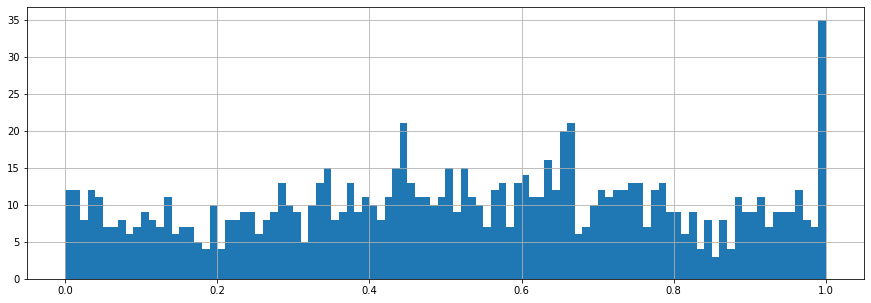

In [11]:
tmp['mean'].hist(figsize=(15,5), bins=100)

In [74]:
df[df['inn'] == '7704662966']['vin'].nunique()

103

In [12]:
tmp.head(100).sample(10)

,count,mean
inn,,
5503084944,112,0.017857
5032242925,329,0.033435
1433017302,254,0.102362
3906317193,165,0.084848
8601024177,129,0.015504
0207007806,158,0.056962
6312139922,195,0.092308
1414017258,416,0.045673
7627051656,219,0.036530


#  ВРЕМЯ ЖИЗНИ АВТО В ИНН

In [432]:
tmp = df[['vin', 'inn']].reset_index().set_index('operation_date')

vin_count = df.groupby('vin')['inn'].nunique()
vin_list = vin_count[vin_count > 1].index

In [448]:
df[df['vin'] == 'X89389715E0BZ7872']

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason,new_car
operation_date,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-06,1136,С,2001-01-01,ГАЗ,33081,MDT1,О,4x2,2014.0,X89389715E0BZ7872,11,1,9,NaN,4005.0,6340006071,None,ОТРАДНЫЙ,Грузовые прочие,Коммерческие перевозки,Самарская область,Приволжский ФО,Приволжский ФО,первичная регистрация,True
2018-06-22,1136,С,2018-06-22,ГАЗ,33081,MDT1,О,4x4,2014.0,X89389715E0BZ7872,94,1,1,NaN,4005.0,0274089610,None,Г ОТРАДНЫЙ,Бортовой,Коммерческие перевозки,Самарская область,Приволжский ФО,Приволжский ФО,"Изменение собственника по сделкам, произведенн...",False


In [447]:
vin_count.sample(10)

vin
X895675E180BJ6816    1
X6W382000X0000004    1
X89581968E0AF9008    1
XTC53229CY2122675    1
XVL483320D0001108    1
XTZ43311033469826    1
X8V43118K10000033    1
XTC652003C1274527    1
XTC65115382339674    1
X89389715E0BZ7872    2
Name: inn, dtype: int64

In [474]:
df

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason,new_car
operation_date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-10,1146,С,2001-01-01,SCANIA,G380LA,HDT3,И,4x2,2011.0,YS2G4X20002067028,46,1,4,NaN,7800.0,5046073787,ПОДОЛЬСКИЙ,ПОДОЛЬСК,Тягач седельный,Коммерческие перевозки,Московская область,Центральный ФО,Центральный ФО,изменение места жительства (юридического адрес...,True
2013-01-10,1146,С,2001-01-01,SCANIA,G380LA,HDT3,И,4x2,2011.0,YS2G4X20002067059,46,1,4,NaN,7800.0,5046073787,ПОДОЛЬСКИЙ,ПОДОЛЬСК,Тягач седельный,Коммерческие перевозки,Московская область,Центральный ФО,Центральный ФО,изменение места жительства (юридического адрес...,True
2013-01-10,1146,С,2001-01-01,SCANIA,G380LA,HDT3,И,4x2,2011.0,XLEG4X20005270141,46,1,4,NaN,7660.0,5046073787,ПОДОЛЬСКИЙ,ПОДОЛЬСК,Тягач седельный,Коммерческие перевозки,Московская область,Центральный ФО,Центральный ФО,изменение места жительства (юридического адрес...,True
2013-01-10,1146,С,2001-01-01,SCANIA,G380LA,HDT3,И,4x2,2011.0,XLEG4X20005269487,46,1,4,NaN,7660.0,5046073787,ПОДОЛЬСКИЙ,ПОДОЛЬСК,Тягач седельный,Коммерческие перевозки,Московская область,Центральный ФО,Центральный ФО,изменение места жительства (юридического адрес...,True
2013-01-10,1146,С,2001-01-01,SCANIA,G420LA,HDT3,И,4x2,2011.0,XLEG4X20005266508,46,1,4,NaN,7810.0,5046073787,ПОДОЛЬСКИЙ,ПОДОЛЬСК,Тягач седельный,Коммерческие перевозки,Московская область,Центральный ФО,Центральный ФО,изменение места жительства (юридического адрес...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,1122,С,2020-03-06,HINO,300,MDT1,С,4x2,2013.0,Z8J3878ZED0000180,44,1,6.0,NaN,NaN,5258068806,None,Г НИЖНИЙ НОВГОРОД,Рефрижератор,None,Нижегородская область,Приволжский ФО,Приволжский ФО,"замена номерного агрегата, цвета, изменение ко...",True
2020-03-06,1122,С,2020-03-06,HINO,300,MDT1,С,4x2,2013.0,Z8J3878ZED0000178,44,1,6.0,NaN,NaN,5258068806,None,Г НИЖНИЙ НОВГОРОД,Рефрижератор,None,Нижегородская область,Приволжский ФО,Приволжский ФО,"замена номерного агрегата, цвета, изменение ко...",True
2020-03-06,1122,С,2020-03-06,HINO,300,MDT1,С,4x2,2013.0,Z8J3878ZED0000194,44,1,6.0,NaN,NaN,5258068806,None,Г НИЖНИЙ НОВГОРОД,Рефрижератор,None,Нижегородская область,Приволжский ФО,Приволжский ФО,"замена номерного агрегата, цвета, изменение ко...",True


In [439]:
vin_count.value_counts(normalize=True)

1    0.923400
2    0.071212
3    0.004476
4    0.000883
5    0.000029
Name: inn, dtype: float64

In [437]:
vin_count[vin_count == 5]

vin
X89580820D0DM7026    5
X89580820D0DM7027    5
X89580820D0DM7030    5
X89580820D0DM7031    5
X89586841D0DM7019    5
X89586842D0DM7013    5
X89586842D0DM7014    5
X9PAS02A6CW104497    5
Name: inn, dtype: int64

# КТО КОМУ ПРОДАЕТ

In [349]:
owner_inn = '7726350939'
'5252018830'
'7709786718'
'5000001525'
print(owner_inn)

7203189562


In [456]:
get_vin_history('X89580820D0DM7030')

,vin,inn
operation_date,,
2013-02-13,X89580820D0DM7030,7447190185
2013-04-02,X89580820D0DM7030,0275072360
2015-11-24,X89580820D0DM7030,0272901636
2018-03-23,X89580820D0DM7030,7706660065
2020-03-18,X89580820D0DM7030,0274089610


In [468]:
# SELECT SELLER INN

def get_vin_history(vin, df=tmp):
    return df.query('vin == @vin').sort_index().drop_duplicates('inn', keep='first')

def get_owner_inn_index(inn, inn_list):
    return np.where(inn_list == inn)[0][0]

def get_seller(transaction, owner_inn):
    return transaction.set_index('inn').loc[:owner_inn].index.values[-2]

def get_buyer(transaction, owner_inn):
    return transaction.set_index('inn').loc[owner_inn:].index.values[1]


## get inn
# owner_inn = '5000001525'
owner_inn = np.random.choice(tmp['inn'].unique())
print(owner_inn)
vin_list = tmp.query('inn == @owner_inn')['vin'].unique()

# get all transactions per vin
transactions_per_inn = []
for vin in tqdm(vin_list):
    transactions_per_inn.append(get_vin_history(vin))

# get sellers and buyers    
inn_transactions = list(filter(lambda x: len(x) > 1, transactions_per_inn))
inn_transactions_sellers = list(filter(lambda x: get_owner_inn_index(owner_inn, x['inn']) != 0, inn_transactions))
inn_transactions_buyers = list(filter(lambda x: get_owner_inn_index(owner_inn, x['inn']) != (len(x)-1), inn_transactions))

sellers = Counter(map(lambda x: get_seller(x, owner_inn), inn_transactions_sellers))
buyers = Counter(map(lambda x: get_buyer(x, owner_inn), inn_transactions_buyers))

sellers = pd.DataFrame(sellers.values(), index=sellers.keys(), columns=['n_transactions'])
buyers = pd.DataFrame(buyers.values(), index=buyers.keys(), columns=['n_transactions'])

3812100526


In [473]:
df[['region', 'model']]

,region,model
operation_date,,
2013-01-10,ПОДОЛЬСКИЙ,G380LA
2013-01-10,ПОДОЛЬСКИЙ,G380LA
2013-01-10,ПОДОЛЬСКИЙ,G380LA
2013-01-10,ПОДОЛЬСКИЙ,G380LA
2013-01-10,ПОДОЛЬСКИЙ,G420LA
...,...,...
2020-03-06,None,300
2020-03-06,None,300
2020-03-06,None,300


,n_transactions
5070000155,107
5024063954,2


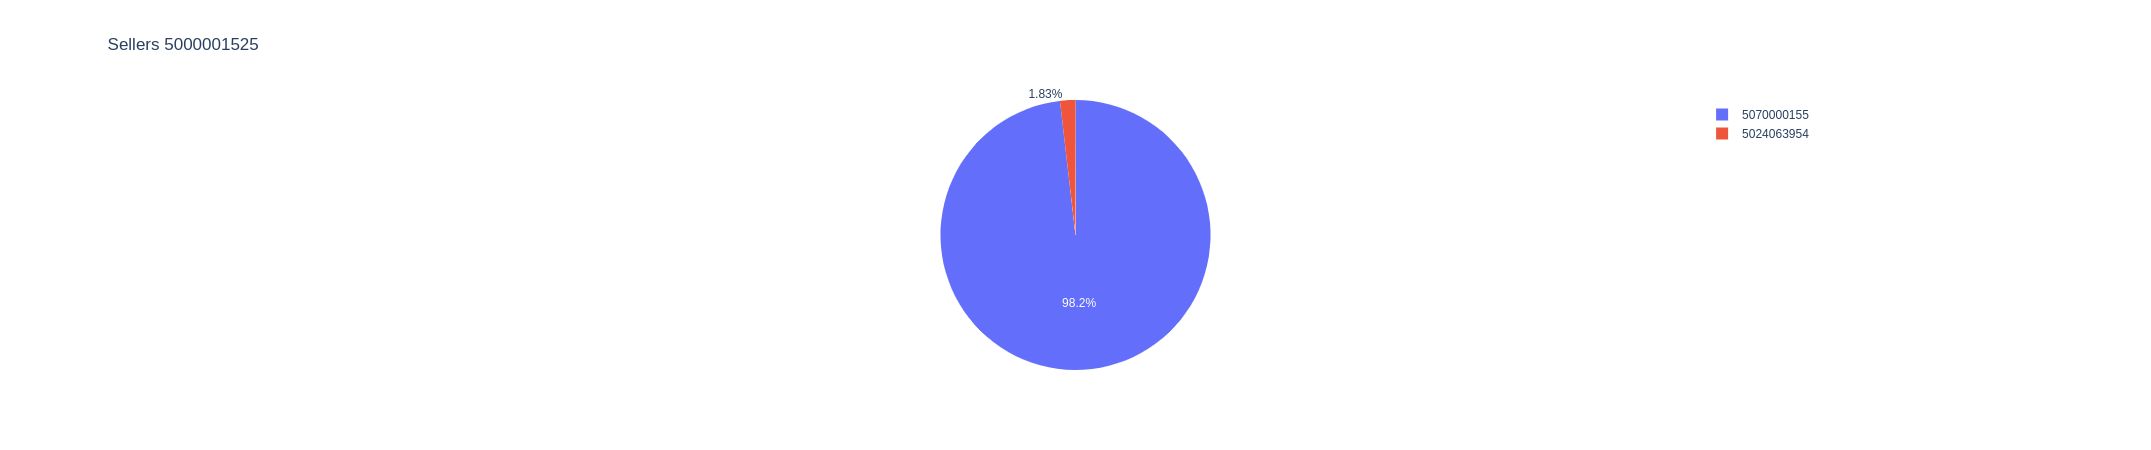

In [465]:
display(sellers)
px.pie(sellers.reset_index(), names='index', values='n_transactions', title='Sellers '+owner_inn)

,n_transactions
4825035530,1
4027067056,2


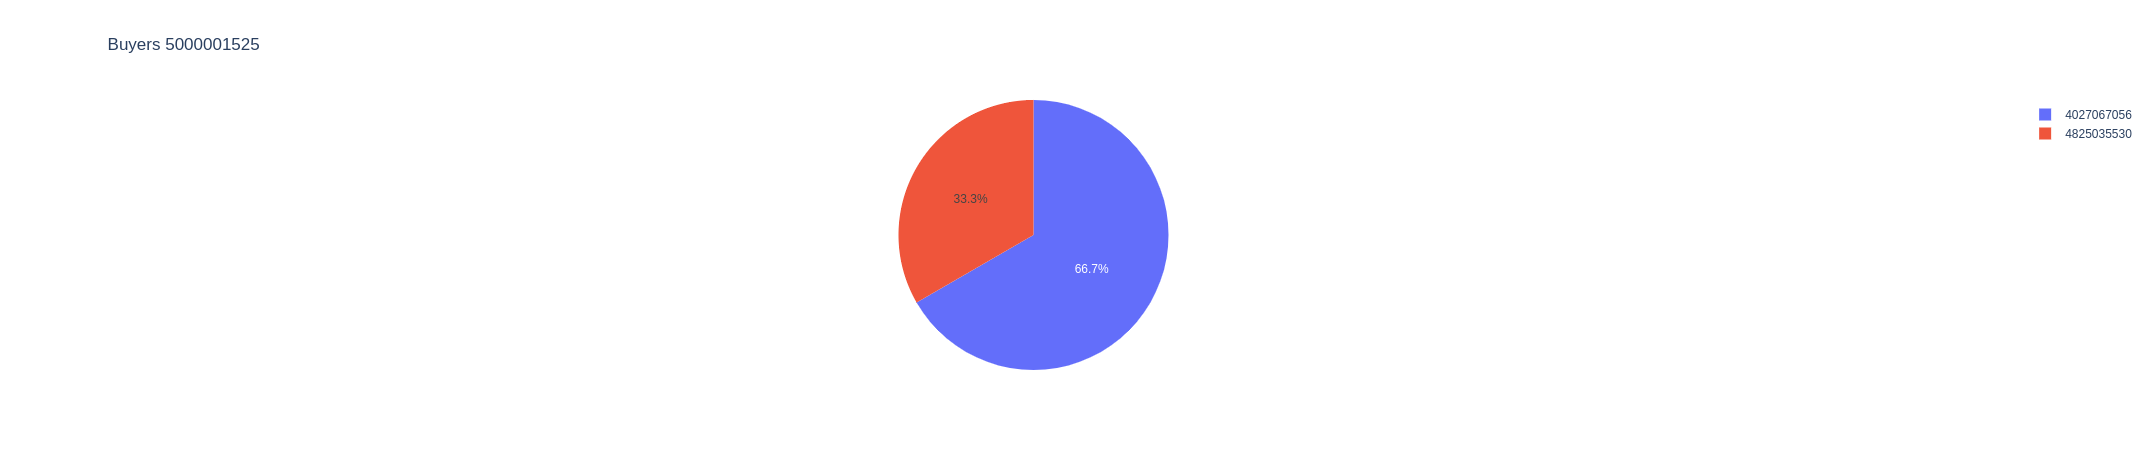

In [466]:
display(buyers)
px.pie(buyers.reset_index(), names='index', values='n_transactions', title='Buyers '+owner_inn)

# КТО У КОГО ПОКУПАЕТ

In [399]:
res = []
for vin, vin_df in tqdm(tmp.loc[vin_list].groupby('vin')):
    res.append(pd.melt(vin_df.sort_values('operation_date')).rename({'value':vin}, axis=1).set_index('variable').T)

In [400]:
vin_df = pd.concat(res)
vin_df.columns = ['date_0', 'date_1', 'inn_0', 'inn_1']

In [204]:
vin_df = vin_df[vin_df['inn_0'] != vin_df['inn_1']]

In [205]:
vin_df['duration'] = (vin_df['date_1'] - vin_df['date_0']).dt.days

In [206]:
duration = vin_df.groupby('inn_0')['duration'].agg(['count', 'mean', 'median'])

In [212]:
vin_df

,date_0,date_1,inn_0,inn_1,duration
1FVABSAK04HM16300,2016-09-20,2018-12-12,8605016593,6674322774,813
1FVDBXAK91HH92177,2016-01-12,2016-12-13,9909012867,7708084402,336
1FVDBXAKX2HK10344,2014-08-12,2016-08-09,7709542704,7708084402,728
1NK0LN9X4PS588678,2013-04-04,2018-12-13,8620006279,8603124113,2079
1NKCMBEX67R194248,2015-09-02,2017-06-22,9909004922,7730665201,659
...,...,...,...,...,...
Z9MFE85DGBG006341,2015-02-02,2016-12-16,3808083370,3810322900,683
Z9MFE85DGBG006342,2015-01-17,2016-12-16,3808083370,3810322900,699
Z9MFE85DGBG006343,2015-01-17,2016-12-16,3808083370,3810322900,699
Z9MFE85DJBG007277,2017-02-28,2018-02-22,6164077483,9705101614,359


In [207]:
duration

,count,mean,median
inn_0,,,
0207007806,1,1440.000000,1440.0
0245014219,57,558.228070,590.0
0265025836,2,520.000000,520.0
0272016783,4,545.500000,203.0
0272901636,26,916.153846,917.5
...,...,...,...
8904069106,6,1886.666667,1983.0
8906006670,5,152.400000,91.0
9909004922,74,686.027027,653.5


In [213]:
res = duration[duration['count'] > 5].sort_values('mean')

In [219]:
res.sort_values('median').head(50).to_csv('../reports/data/truck_lifetime_2013.csv')

In [195]:
res.columns = ['car_count', 'mean_lifetime', 'median_lifetime']

In [198]:
res.to_csv('../reports/data/truck_lifetime.csv')

In [199]:
res

,car_count,mean_lifetime,median_lifetime
inn_0,,,
7730117815,7,19.857143,12.0
7709404341,26,31.576923,22.0
8602053340,30,39.733333,28.0
0272901636,16,72.500000,62.0
2310053662,7,76.857143,78.0
6713006091,8,87.750000,53.0
6376000010,21,89.619048,69.0
7702616611,6,99.500000,54.0
7723339969,6,99.666667,123.5


# Прогноз продажи авто

In [360]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_parquet('../data/processed/gibdd.parquet')
df.shape

(2088946, 24)

In [4]:
df.head()

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637211C0EM2028,11,1,9,NaN,11740.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637210C0EM2030,11,1,9,NaN,9590.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8-360-031,HDT2,И,4x2,2008.0,Y3M5440A880000074,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
2013-01-09,1146,С,2001-01-01,МАЗ,437043,HDT1,И,4x2,2008.0,Y3M43704380000253,12,1,1,NaN,4800.0,5029166093,МЫТИЩИНСКИЙ Р-Н,МЫТИЩИ,Бортовой,None,Московская область,Центральный ФО,Центральный ФО,"регистрация, снятых с учета"
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8,HDT2,И,4x2,2008.0,Y3M5440A880000181,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений


In [6]:
df['operation_reason'].value_counts(normalize=True)

Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков                                        5.065339e-01
первичная регистрация                                                                                                                                      2.126993e-01
изменение Ф.И.О. (наименования) владельца                                                                                                                  8.667288e-02
замена государственного регистрационного знака                                                                                                             7.655945e-02
замена номерного агрегата, цвета, изменение конструкции ТС                                                                                                 4.305183e-02
регистрация, снятых с учета                                                                                                                                4.072

In [30]:
buf = df[['year', 'vin', 'brand', 'inn', 'operation_reason']].copy()
buf['operation_year'] = buf.index.year
buf['operation_month'] = buf.index.month

In [32]:
buf[(buf['operation_year'] == 2018) & (buf['operation_month'] <= 10) & (buf['brand'] == 'КАМАЗ')]['operation_reason'].value_counts()

Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков    46003
первичная регистрация                                                                                                  21021
замена государственного регистрационного знака                                                                          7262
изменение Ф.И.О. (наименования) владельца                                                                               6649
замена номерного агрегата, цвета, изменение конструкции ТС                                                              5009
регистрация, снятых с учета                                                                                             2622
Name: operation_reason, dtype: int64

In [33]:
buf[(buf['operation_year'] == 2020) & (buf['brand'] == 'КАМАЗ')]['operation_reason'].value_counts()

Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков    9006
первичная регистрация                                                                                                  5587
изменение Ф.И.О. (наименования) владельца                                                                              2165
замена государственного регистрационного знака                                                                         1347
замена номерного агрегата, цвета, изменение конструкции ТС                                                             1073
регистрация, снятых с учета                                                                                             530
Name: operation_reason, dtype: int64

In [39]:
buf[(buf['operation_year'] == 2019) & (buf['brand'] == 'КАМАЗ')]['operation_reason'].value_counts(normalize=True)

Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков    0.525864
первичная регистрация                                                                                                  0.247915
замена государственного регистрационного знака                                                                         0.070316
замена номерного агрегата, цвета, изменение конструкции ТС                                                             0.065012
изменение Ф.И.О. (наименования) владельца                                                                              0.058261
регистрация, снятых с учета                                                                                            0.032484
коррекция иных реквизитов                                                                                              0.000148
Name: operation_reason, dtype: float64

In [37]:
(buf['operation_year'] - buf['year']).value_counts(normalize=True)

0.0     0.160238
1.0     0.092438
3.0     0.066424
4.0     0.055101
5.0     0.053973
2.0     0.053230
6.0     0.052278
7.0     0.045313
8.0     0.040717
9.0     0.039029
10.0    0.038532
11.0    0.038025
12.0    0.032515
13.0    0.025296
14.0    0.021592
15.0    0.018816
16.0    0.016723
17.0    0.014569
18.0    0.012912
25.0    0.012882
24.0    0.012518
26.0    0.011956
19.0    0.011633
23.0    0.011555
20.0    0.010576
22.0    0.010048
27.0    0.009776
21.0    0.009708
28.0    0.007523
29.0    0.005368
30.0    0.003654
31.0    0.002323
32.0    0.001318
33.0    0.000632
34.0    0.000342
35.0    0.000210
36.0    0.000143
37.0    0.000079
38.0    0.000033
39.0    0.000003
dtype: float64

In [4]:
tmp = df[['year', 'vin', 'inn', 'operation_reason']].copy()
tmp['operation_year'] = tmp.index.year

In [5]:
tmp['operation_reason'].value_counts(normalize=True).round(4).head(5)

Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков    0.5065
первичная регистрация                                                                                                  0.2127
изменение Ф.И.О. (наименования) владельца                                                                              0.0867
замена государственного регистрационного знака                                                                         0.0766
замена номерного агрегата, цвета, изменение конструкции ТС                                                             0.0431
Name: operation_reason, dtype: float64

In [6]:
tmp[(tmp['operation_year'] == tmp['year'])]['operation_reason'].value_counts(normalize=True).round(4).head(5)

первичная регистрация                                                                                                    0.9061
временная регистрация ТС (на срок проведения проверок, на срок временной прописки, регистрация испытательной техники)    0.0283
Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков      0.0191
замена номерного агрегата, цвета, изменение конструкции ТС                                                               0.0102
замена государственного регистрационного знака                                                                           0.0096
Name: operation_reason, dtype: float64

In [7]:
tmp[(tmp['operation_year'] == tmp['year']) & (tmp['operation_reason'] == 'первичная регистрация')]

,year,vin,inn,operation_reason,operation_year
operation_date,,,,,
2013-01-25,2013.0,X89560302D0EP9005,1834100340,первичная регистрация,2013
2013-01-28,2013.0,X89560313D0EP9002,1835038790,первичная регистрация,2013
2013-01-25,2013.0,X89637027D8FB5183,1650130591,первичная регистрация,2013
2013-01-28,2013.0,X89594314D0DM6012,1650241446,первичная регистрация,2013
2013-01-23,2013.0,Z9G438922D0000395,5022039177,первичная регистрация,2013
...,...,...,...,...,...
2020-03-12,2020.0,Z783010GDL0061984,5243024235,первичная регистрация,2020
2020-02-01,2020.0,Z783010GAL0061879,3320005130,первичная регистрация,2020
2020-02-04,2020.0,X895796Y2L0EY5021,3304000103,первичная регистрация,2020


In [8]:
tmp = tmp[df['operation_reason'] == 'первичная регистрация']

In [9]:
tmp

,year,vin,inn,operation_reason,operation_year
operation_date,,,,,
2013-01-15,2012.0,X89637211C0EM2028,2901221866,первичная регистрация,2013
2013-01-15,2012.0,X89637210C0EM2030,2901221866,первичная регистрация,2013
2013-01-10,2012.0,XUH27990AC0000918,5075019819,первичная регистрация,2013
2013-01-10,2012.0,X5V580421C0000280,5032033791,первичная регистрация,2013
2013-01-10,2012.0,X5V580421C0000281,5032033791,первичная регистрация,2013
...,...,...,...,...,...
2020-03-06,2019.0,XUY3813G0L0000809,5260200603,первичная регистрация,2020
2020-03-06,2019.0,XUY3813G0L0000810,5260200603,первичная регистрация,2020
2020-03-06,2020.0,Z783010GDL0061957,5036170703,первичная регистрация,2020


In [14]:
(tmp['operation_year'] - tmp['year']).value_counts(normalize=True)

0.0     0.682656
1.0     0.264446
2.0     0.023550
3.0     0.013761
4.0     0.004772
5.0     0.002901
6.0     0.002161
7.0     0.001441
8.0     0.000921
9.0     0.000608
10.0    0.000560
11.0    0.000340
13.0    0.000257
12.0    0.000254
14.0    0.000214
15.0    0.000185
16.0    0.000167
17.0    0.000097
18.0    0.000081
25.0    0.000070
19.0    0.000065
23.0    0.000063
20.0    0.000061
22.0    0.000056
30.0    0.000056
24.0    0.000050
21.0    0.000045
27.0    0.000043
31.0    0.000036
26.0    0.000027
28.0    0.000025
29.0    0.000016
32.0    0.000009
33.0    0.000005
35.0    0.000002
36.0    0.000002
dtype: float64

# lets find cars we are sure are bought on primary market

In [113]:
df.head()

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637211C0EM2028,11,1,9,NaN,11740.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637210C0EM2030,11,1,9,NaN,9590.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8-360-031,HDT2,И,4x2,2008.0,Y3M5440A880000074,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
2013-01-09,1146,С,2001-01-01,МАЗ,437043,HDT1,И,4x2,2008.0,Y3M43704380000253,12,1,1,NaN,4800.0,5029166093,МЫТИЩИНСКИЙ Р-Н,МЫТИЩИ,Бортовой,None,Московская область,Центральный ФО,Центральный ФО,"регистрация, снятых с учета"
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8,HDT2,И,4x2,2008.0,Y3M5440A880000181,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений


In [1115]:
df['affiliation'] = pd.Categorical(df['affiliation'].astype(float))
df['code'] = pd.Categorical(df['code'].astype(float))
df['brand'] = pd.Categorical(df['brand'])
df['region'] = pd.Categorical(df['region'])

In [1116]:
FEATURES = ['brand', 'region', 'mass_idle',] # 'affiliation', 'code']

In [1117]:
MAX_OPERATION_YEAR_GAP = 2

primary_market = df[df['operation_reason'] == 'первичная регистрация'][['vin', 'year']]
primary_market['operation_year'] = primary_market.index.year
primary_market = primary_market[(primary_market['operation_year'] - primary_market['year']) <= MAX_OPERATION_YEAR_GAP]

In [1130]:
len(df.loc['2019'].query('operation_reason != "первичная регистрация"'))

304758

In [1137]:
df.loc[df['operation_reason'].isin(['регистрация, снятых с учета', 'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков'])].loc['2019'].query('brand == "КАМАЗ"').shape

(64009, 24)

In [1133]:
df.loc['2019'].query('operation_reason != "первичная регистрация"').query('brand == "КАМАЗ"')['vin'].nunique()

78856

In [1120]:
df[df['operation_reason'] == 'первичная регистрация'][['vin', 'year']].shape

(444288, 2)

In [1118]:
primary_market.shape

(431249, 3)

In [1119]:
df.shape

(2088946, 24)

In [574]:
# primary registration can occur only once
tmp = primary_market['vin'].value_counts()
primary_vin = tmp[tmp == 1].index.tolist()
del tmp

In [578]:
secondary_market = df[df['vin'].isin(primary_vin)][['vin', 'inn', 'operation_reason']+FEATURES]

tmp = secondary_market['vin'].value_counts()
secondary_vin = tmp[tmp == 2].index.tolist()
secondary_market = secondary_market[secondary_market['vin'].isin(secondary_vin)]

tmp = secondary_market.groupby('vin')['inn'].nunique()
secondary_vin = tmp[tmp == 2].index.tolist()
secondary_market = secondary_market[secondary_market['vin'].isin(secondary_vin)]

secondary_market['date'] = secondary_market.index


###########################################################################################

secondary_market.set_index('vin', inplace=True)
secondary_market.sort_values('date', inplace=True)

secondary_market['date_sell'] = secondary_market.groupby('vin')['date'].last()
secondary_market['date_buy'] = secondary_market.groupby('vin')['date'].first()

secondary_market['days'] = (secondary_market['date_sell'] - secondary_market['date_buy']).dt.days

del tmp

secondary_market['year_buy'] = secondary_market['date_buy'].dt.year
secondary_market['month_buy'] = secondary_market['date_buy'].dt.month

In [579]:
secondary_market = secondary_market.reset_index().set_index('date_sell').sort_index()

In [581]:
secondary_market.drop('date', axis=1, inplace=True)

In [582]:
secondary_market

,vin,inn,operation_reason,brand,region,mass_idle,date_buy,days,year_buy,month_buy
date_sell,,,,,,,,,,
2013-02-08,X89385810C0BW1038,6165031467,"Изменение собственника по сделкам, произведенн...",КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-01-19,20,2013,1
2013-02-08,X89385810C0BW1038,6165154243,первичная регистрация,КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-01-19,20,2013,1
2013-02-08,X89594321D0DM6078,1650241446,первичная регистрация,КАМАЗ,ЦЕНТРАЛЬНЫЙ,9960.0,2013-01-30,9,2013,1
2013-02-08,X89594321D0DM6078,5617020341,"регистрация ТС, прибывших из других регионов РФ",КАМАЗ,СОРОЧИНСКИЙ,10685.0,2013-01-30,9,2013,1
2013-02-14,X89282027C0CV8008,7710474791,первичная регистрация,IVECO,ТВЕРСКОЙ (ЦАО) Р-Н,8900.0,2013-01-23,22,2013,1
...,...,...,...,...,...,...,...,...,...,...
2020-03-31,XDK37045CJ0000043,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000042,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000040,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3


In [583]:
df.head()

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637211C0EM2028,11,1.0,9.0,NaN,11740.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637210C0EM2030,11,1.0,9.0,NaN,9590.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8-360-031,HDT2,И,4x2,2008.0,Y3M5440A880000074,47,1.0,4.0,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
2013-01-09,1146,С,2001-01-01,МАЗ,437043,HDT1,И,4x2,2008.0,Y3M43704380000253,12,1.0,1.0,NaN,4800.0,5029166093,МЫТИЩИНСКИЙ Р-Н,МЫТИЩИ,Бортовой,None,Московская область,Центральный ФО,Центральный ФО,"регистрация, снятых с учета"
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8,HDT2,И,4x2,2008.0,Y3M5440A880000181,47,1.0,4.0,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений


In [584]:
X

,brand,region,mass_idle,year_buy,month_buy
date_sell,,,,,
2013-02-08,камаз,nan,10580.0,2013,1
2013-02-08,камаз,nan,10580.0,2013,1
2013-02-08,камаз,центральный,9960.0,2013,1
2013-02-08,камаз,nan,10685.0,2013,1
2013-02-14,iveco,nan,8900.0,2013,1
...,...,...,...,...,...
2020-03-31,isuzu,nan,NaN,2018,3
2020-03-31,isuzu,nan,NaN,2018,3
2020-03-31,isuzu,nan,NaN,2018,3


In [585]:
y.sample(10)

date_sell
2017-03-17     364
2018-12-04     599
2019-06-07     595
2020-03-24     133
2019-12-14    2277
2019-04-23     273
2015-12-03     674
2018-09-21     408
2019-06-13     703
2020-02-07    1392
Name: days, dtype: int64

In [498]:
secondary_market

,vin,inn,operation_reason,brand,region,mass_idle,date,date_buy,days,year_buy,month_buy
date_sell,,,,,,,,,,,
2013-02-08,X89385810C0BW1038,6165031467,"Изменение собственника по сделкам, произведенн...",КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-02-08,2013-01-19,20,2013,1
2013-02-08,X89385810C0BW1038,6165154243,первичная регистрация,КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-01-19,2013-01-19,20,2013,1
2013-02-08,X89594321D0DM6078,1650241446,первичная регистрация,КАМАЗ,ЦЕНТРАЛЬНЫЙ,9960.0,2013-01-30,2013-01-30,9,2013,1
2013-02-08,X89594321D0DM6078,5617020341,"регистрация ТС, прибывших из других регионов РФ",КАМАЗ,СОРОЧИНСКИЙ,10685.0,2013-02-08,2013-01-30,9,2013,1
2013-02-14,X89282027C0CV8008,7710474791,первичная регистрация,IVECO,ТВЕРСКОЙ (ЦАО) Р-Н,8900.0,2013-01-23,2013-01-23,22,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,XDK37045CJ0000043,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000042,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000040,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,2018-03-30,732,2018,3


In [516]:
secondary_market['region'] = secondary_market['region'].str.lower().str.replace('р-н','').str.replace('[^\w\s]','').str.strip()
region_list = secondary_market['region'].value_counts().head(30).index.tolist()
secondary_market.loc[~secondary_market['region'].isin(region_list), 'region'] = np.nan

In [531]:
secondary_market['brand'] = secondary_market['brand'].astype(str).str.lower()

In [532]:
X = secondary_market[FEATURES + ['year_buy', 'month_buy']]
# X = secondary_market[['mass_idle'] + ['year_buy', 'month_buy']]
y = secondary_market['days']

In [421]:
# X['affiliation'] = X['affiliation'].astype(float)
# X['code'] = X['code'].astype(float)

In [543]:
X['brand'] = pd.Categorical(X['brand'].astype(str))
X['region'] = pd.Categorical(X['region'].astype(str))

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [545]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor

In [546]:
cat_features = X.dtypes[X.dtypes == 'category'].index.tolist()

In [549]:
model = CatBoostRegressor(n_estimators=10_000, learning_rate=0.1, cat_features=cat_features, loss_function='MAE').fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)

0:	learn: 741.3988495	test: 744.0718075	best: 744.0718075 (0)	total: 36.2ms	remaining: 6m 2s
1:	learn: 682.0735597	test: 684.7798136	best: 684.7798136 (1)	total: 66.1ms	remaining: 5m 30s
2:	learn: 629.9272639	test: 632.5259726	best: 632.5259726 (2)	total: 100ms	remaining: 5m 33s
3:	learn: 585.3187225	test: 587.9842886	best: 587.9842886 (3)	total: 137ms	remaining: 5m 42s
4:	learn: 551.6994847	test: 554.5362086	best: 554.5362086 (4)	total: 168ms	remaining: 5m 35s
5:	learn: 520.5267930	test: 523.3891884	best: 523.3891884 (5)	total: 199ms	remaining: 5m 31s
6:	learn: 493.4613009	test: 496.2077751	best: 496.2077751 (6)	total: 236ms	remaining: 5m 37s
7:	learn: 469.3877491	test: 471.8765430	best: 471.8765430 (7)	total: 270ms	remaining: 5m 36s
8:	learn: 449.0994363	test: 451.5710901	best: 451.5710901 (8)	total: 311ms	remaining: 5m 44s
9:	learn: 431.5879904	test: 434.1108421	best: 434.1108421 (9)	total: 354ms	remaining: 5m 53s
10:	learn: 416.4528570	test: 419.0541887	best: 419.0541887 (10)	total

In [341]:
# model = LGBMRegressor(n_estimators=20).fit(X,y)

In [587]:
model.score(X_test, y_test)

0.4093719902343502

In [588]:
mean_absolute_error(np.full_like(y, np.full_like(y, y.median())), y)

438.9853954605804

In [589]:
mean_squared_error(model.predict(X), y)

176754.60487106777

In [590]:
mean_absolute_error(model.predict(X), y)

297.7777315973977

In [554]:
pred = model.predict(X)

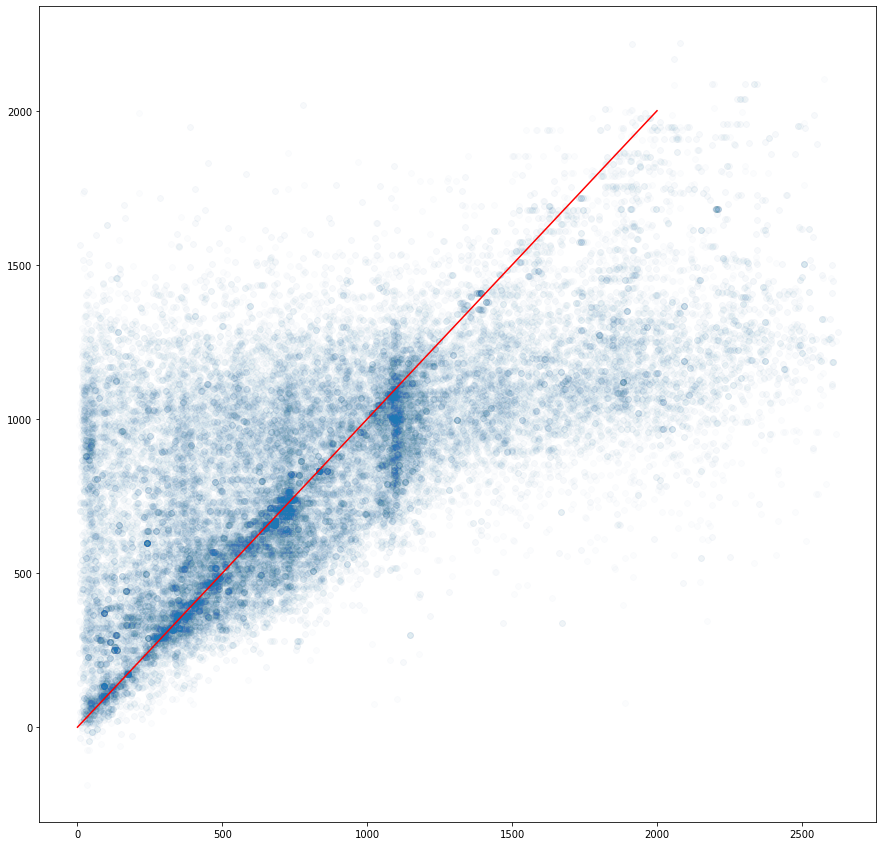

In [559]:
plt.figure(figsize=(15,15))
plt.scatter(y, pred, alpha=0.015)
plt.plot([0,2000], [0,2000], color='red')
plt.show()

In [592]:
pred = y.copy()

In [595]:
inn = secondary_market[['inn']].copy()

In [597]:
inn['pred'] = pred

In [600]:
secondary_market

,vin,inn,operation_reason,brand,region,mass_idle,date_buy,days,year_buy,month_buy
date_sell,,,,,,,,,,
2013-02-08,X89385810C0BW1038,6165031467,"Изменение собственника по сделкам, произведенн...",КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-01-19,20,2013,1
2013-02-08,X89385810C0BW1038,6165154243,первичная регистрация,КАМАЗ,РОСТОВ-НА-ДОНУ,10580.0,2013-01-19,20,2013,1
2013-02-08,X89594321D0DM6078,1650241446,первичная регистрация,КАМАЗ,ЦЕНТРАЛЬНЫЙ,9960.0,2013-01-30,9,2013,1
2013-02-08,X89594321D0DM6078,5617020341,"регистрация ТС, прибывших из других регионов РФ",КАМАЗ,СОРОЧИНСКИЙ,10685.0,2013-01-30,9,2013,1
2013-02-14,X89282027C0CV8008,7710474791,первичная регистрация,IVECO,ТВЕРСКОЙ (ЦАО) Р-Н,8900.0,2013-01-23,22,2013,1
...,...,...,...,...,...,...,...,...,...,...
2020-03-31,XDK37045CJ0000043,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000042,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3
2020-03-31,XDK37045CJ0000040,6154129710,первичная регистрация,ISUZU,NaN,NaN,2018-03-30,732,2018,3


In [602]:
inn.groupby('inn')['pred'].min()

inn
0010111626     730
0053180085    1925
0101006023     932
0101006922     868
0101011520     422
              ... 
9909396885    1340
9909403733     732
9909413675     412
9909422817     855
9909429160    1684
Name: pred, Length: 20719, dtype: int64

In [601]:
inn.groupby('inn')['pred'].mean()

inn
0010111626     730.000000
0053180085    1925.000000
0101006023     932.000000
0101006922     868.000000
0101011520     656.333333
                 ...     
9909396885    1340.000000
9909403733     733.500000
9909413675     412.333333
9909422817    1074.482353
9909429160    1684.000000
Name: pred, Length: 20719, dtype: float64

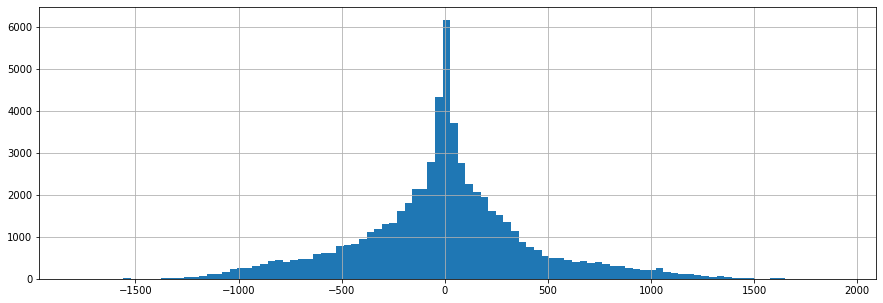

In [556]:
(y - pred).hist(bins=100, figsize=(15,5))

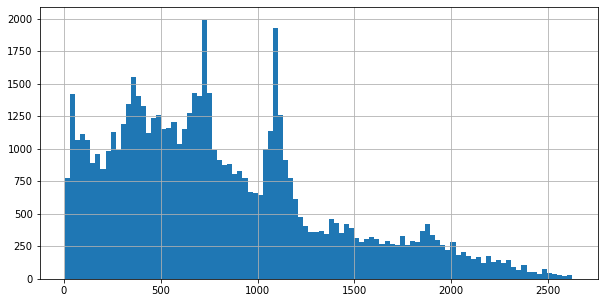

In [300]:
y.hist(bins=100, figsize=(10,5))
plt.show()

In [346]:
model.predict(X)

array([1015.11273408, 1015.11273408, 1197.51459272, ...,   95.75580363,
        232.96639641,  116.52220233])

In [557]:
X

,brand,region,mass_idle,year_buy,month_buy
date_sell,,,,,
2013-02-08,камаз,nan,10580.0,2013,1
2013-02-08,камаз,nan,10580.0,2013,1
2013-02-08,камаз,центральный,9960.0,2013,1
2013-02-08,камаз,nan,10685.0,2013,1
2013-02-14,iveco,nan,8900.0,2013,1
...,...,...,...,...,...
2020-03-31,isuzu,nan,NaN,2018,3
2020-03-31,isuzu,nan,NaN,2018,3
2020-03-31,isuzu,nan,NaN,2018,3


In [558]:
model.feature_importances_

array([10.9475245 ,  6.66314739, 27.44040944, 46.82541503,  8.12350365])

In [606]:
y[y>3 65].mean()/365

2.7609080487531084

# INN TRANSACTIONS MATRIX

In [10]:
df = pd.read_parquet('../data/processed/gibdd.parquet')
df.shape

df = df[['inn', 'vin', 'operation_reason']]
df.sort_index(inplace=True)
df.head()

df.dropna(inplace=True)
df.drop_duplicates(['inn', 'vin'], keep='first', inplace=True)

vin_list = df['vin'].unique()

vin_path_len =df.groupby('vin')['inn'].nunique().sort_values(ascending=False)
vin_path_len = vin_path_len[vin_path_len > 1]

vin_path = df.query('vin == @vin')['inn'].tolist()

df = df[df['vin'].isin(vin_path_len.index)]

inn_list = df['inn'].unique()

In [337]:
def get_inn_index(inn, inn_list):
    return [np.where(np.isin(inn_list, i))[0][0] for i in inn]


def get_transaction_sample(seller_list, buyer_list, transaction_matrix, inn_list):
    
    seller_ind = get_inn_index(seller_list, inn_list)
    buyer_ind = get_inn_index(buyer_list, inn_list)
        
    return transaction_matrix[seller_ind][:,buyer_ind]


def transaction_dataframe(seller_list, buyer_list, transaction_matrix, inn_list):
    
    transaction_matrix = get_transaction_sample(seller_list, buyer_list, transaction_matrix, inn_list)
    return pd.DataFrame(transaction_matrix.toarray(), index=seller_list, columns=buyer_list).astype(int)

In [ ]:
# from scipy.sparse import lil_matrix
# transactions_matrix = lil_matrix((len(inn_list),len(inn_list)))
# inn_list = df['inn'].unique()


# for vin in tqdm(vin_list):
#     vin_path = df.query('vin == @vin')['inn'].tolist()
#     transaction_list = [vin_path[i:i+2] for i in range(len(vin_path) - 1)]
#     for transaction in transaction_list:
#         seller, buyer = transaction[0], transaction[1]
#         seller_ind, buyer_ind = get_inn_index(seller, inn_list), get_inn_index(buyer, inn_list)
#         transactions_matrix[seller_ind, buyer_ind] += 1

In [595]:
seller_list = ['6671335486',
 '5024063739',
 '7724879967',
 '7724351310',
 '5047056255',
 '7805327989',
 '5032048798']


buyer_list = seller_list.copy()

transaction_dataframe(seller_list, buyer_list, transactions_matrix, inn_list)

,6671335486,5024063739,7724879967,7724351310,5047056255,7805327989,5032048798
6671335486,0,5,0,0,0,0,18
5024063739,0,0,5,0,0,0,0
7724879967,0,0,0,5,0,0,0
7724351310,0,0,0,0,3,0,0
5047056255,0,0,0,0,0,1,30
7805327989,0,0,0,0,0,0,2
5032048798,0,0,0,0,14,0,0


In [306]:
# from scipy import sparse
# import pickle

# sparse.save_npz('../data/processed/transactions.npz', transactions_matrix.tocsr())
# with open('../data/processed/inn_list.pkl', 'wb') as f:
#     pickle.dump(inn_list, f)

In [395]:
import warnings
warnings.simplefilter('ignore')

In [397]:
holdings = pd.read_csv('/home/jovyan/remote_shared_data/dsdiag222/gibdd_dataset_raw/holdings.csv', delimiter=';', error_bad_lines=False)
holding_names = pd.read_csv('/home/jovyan/remote_shared_data/dsdiag222/gibdd_dataset_raw/holdings_names.csv', delimiter=';', error_bad_lines=False)
company_status = pd.read_csv('/home/jovyan/remote_shared_data/dsdiag222/gibdd_dataset_raw/company_status.csv', delimiter=';', error_bad_lines=False, warn_bad_lines=False)

holdings['Код налогоплательщика'] = holdings['Код налогоплательщика'].astype(str)
inn_mask = holdings['Код налогоплательщика'].str.len() == 9
holdings.loc[inn_mask, 'Код налогоплательщика'] = holdings.loc[inn_mask, 'Код налогоплательщика'].apply(lambda x: '0'+x)

holdings = pd.merge(holdings, company_status[['ИНН', 'Вид деятельности/отрасль', 'Количество', 'Регион регистрации']], how='left', left_on='INN', right_on='ИНН').drop('ИНН', axis=1).rename({
    'Вид деятельности/отрасль':'department',
    'Количество':'quantity',
    'Регион регистрации':'region',
}, axis=1)

holdings = holdings.drop_duplicates(['INN'])
holdings.set_index('INN', inplace=True)

display(holdings.sample(10))
display(holding_names.sample(10))
display(company_status.sample(10), )

b'Skipping line 1092: expected 4 fields, saw 5\n'
b'Skipping line 1759: expected 3 fields, saw 4\n'


,Наименование,Код налогоплательщика,Группа,ИНН
661,"ЖКС КРОНШТАДТСКОГО РАЙОНА, ООО",7843307888,КИО,7832000076
606,"РСП ТПК КГРЭС, АО",4431002987,"ИНТЕР РАО, ПАО",2320109650
602,"БАШЭНЕРГОТРАНС, ООО",276090347,"ИНТЕР РАО, ПАО",2320109650
1049,"АТОМСПЕЦТРАНС, АО",7717609102,"РОСАТОМ, ГОСКОРПОРАЦИЯ",7706413348
121,"УРАЛВТОРЧЕРМЕТ, ООО",6679065866,FLETCHER GROUP HOLDINGS LIMITED,200055570
567,"РТИ, АО",7713723559,Евтушенков Владимир Петрович,771000084662
143,"ВИКТОРИЯ, ООО СХП",6808004751,SUCRES ET DENREES,200059105
643,"КДВ ЯШКИНО, ООО",4246006730,"КДВ, АО",7017166840
215,БАНК ВТБ (ПАО),7702070139,БАНК ВТБ (ПАО),7702070139
865,"ЧЕЧВОДОКАНАЛ, ГУП",2013001100,МИНИСТЕРСТВО ИМУЩЕСТВЕННЫХ И ЗЕМЕЛЬНЫХ ОТНОШЕН...,2014024069


,инн,клиент,предприятие
2570,5610084427,МЧС России,ГЛАВНОЕ УПРАВЛЕНИЕ МЧС РОССИИ ПО ОРЕНБУРГСКОЙ ...
939,3327824805,МЧС России,ФГБУ СЭУ ФПС ИПЛ ПО ВЛАДИМИРСКОЙ ОБЛАСТИ
480,1645000406,"ПАО ""Татнефть""","ООО ""Татнефтедор"""
2784,5047011261,МЧС России,"АКАДЕМИЯ ГРАЖДАНСКОЙ ЗАЩИТЫ МЧС РОССИИ, ФГБВОУ ВО"
603,6829077655,ФСИН России,"УИИ УФСИН РОССИИ ПО ТАМБОВСКОЙ ОБЛАСТИ, ФКУ"
2930,4209008915,МЧС России,"1 ОТРЯД ФПС ПО КЕМЕРОВСКОЙ ОБЛАСТИ, ФГКУ"
3235,3403015573,ФСИН России,"ИК-9 УФСИН РОССИИ ПО ВОЛГОГРАДСКОЙ ОБЛАСТИ, ФКУ"
1158,1632008060,"ООО ""ТАГРАС-ХОЛДИНГ""","ООО ""ТрансСервисНурлат"""
3425,2612018209,ФСИН России,"БМТИВС УФСИН РОССИИ ПО СТАВРОПОЛЬСКОМУ КРАЮ, ФКУ"
2734,5007025268,"ООО ""Стройгазконсалтинг""",ООО «Стройгарант»


,Наименование владельца,Статус,Размер компании,ИНН,Регион регистрации,Важная информация,Вид деятельности/отрасль,Руководитель - ФИО,Телефон,Электронный адрес,Сайт в сети Интернет,ИФР,Индикатор ИФР,"Возраст компании, лет",Количество,Количество сед# тягач# (4x2),"2018, Выручка, млн# руб#","2018, Чистая прибыль (убыток), млн# руб#","2018, EBIT, млн# руб#","2018, Основные средства , млн# руб#","2018, Запасы, млн# руб#","2018, Дебиторская задолженность, млн# руб#","2018, Кредиторская задолженность, млн# руб#","Сумма незавершенных исков в роли ответчика, млн# руб#",Сумма исполнительных производств,"2018, Чистые активы, млн# руб#","2018, Уставный капитал , млн# руб#","2018, Коэффициент соотношения заемных и собственных средств, %","2018, Коэффициент маневренности собственных средств, %","2018, Коэффициент обеспеченности собственными оборотными средств","2018, Коэффициент текущей ликвидности, %","2018, Внеоборотные активы, млн# руб#",F33
77388,ООО ЮГТРАНС,Действующая,Микропредприятия,2320114280,Краснодарский край,NaN,Перевозка грузов неспециализированными автотра...,Саракашиш Христофор Константинович,"+7 (862) 2649410, +7 (862) 2938236, +7 (918) 2...",#,#,14.0,Низкий риск,28,4,NaN,"0,41499999999999998","0,20599999999999999","0,218","8,0000000000000002E-3",NaN,NaN,"0,016",NaN,NaN,"-0,35999999999999999",NaN,"-1,0222","1,0222",0,0,"8,0000000000000002E-3",NaN
47088,МУПРАКИТ.ВОДОКАНАЛ,Не присвоен,NaN,NaN,Не присвоен,NaN,Не присвоен,NaN,NaN,NaN,NaN,NaN,Не присвоен,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96802,ООО ШПУНТЫ И СВАИ,Действующая,Малые предприятия,9701002644,Москва,NaN,Строительство жилых и нежилых зданий,Джумаев Тимур Валерьевич,+7 (916) 9718807,#,#,89.0,Высокий риск,"4,5",2,NaN,"136,56800000000001","-6,8540000000000001","-6,7320000000000002","24,062999999999999","7,1859999999999999","43,865000000000002","101,2","0,58584999999999998","0,030161","-12,496","0,01","-8,0985999999999994","2,9411999999999998","-0,57030000000000003","0,63680000000000003","24,257000000000001",NaN
42785,ОАО ПСХК САРАНСК-СТРОЙЗАКАЗЧИК,Не присвоен,NaN,NaN,Не присвоен,NaN,Не присвоен,NaN,NaN,NaN,NaN,NaN,Не присвоен,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79690,ООО МОНТАЖАВТОМАТИКА,Действующая,Микропредприятия,7826180790,Не присвоен,NaN,Не присвоен,Австрейх Арон Давыдович,"+7 (812) 3234779, +7 (812) 3285312",#,#,7.0,Низкий риск,"16,5",1,NaN,"11,677","0,27800000000000002","0,38100000000000001","0,11799999999999999","1,5469999999999999","1,718","2,5089999999999999",0,NaN,"0,28799999999999998",NaN,"11,3194","0,59030000000000005","4,9599999999999998E-2","1,0525","0,11799999999999999",NaN
75093,МП БИГИНДБИГИНД,Не присвоен,NaN,NaN,Не присвоен,NaN,Не присвоен,NaN,NaN,NaN,NaN,NaN,Не присвоен,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47857,АРТЕЛЬ УРАЛ-НОРД,Действующая,#,6610003268,Свердловская область,NaN,Добыча руд и песков драгоценных металлов (золо...,Набиуллин Фарит Минниахметович,"+7 (343) 1621295, +7 (343) 1622120, +7 (343) 1...",ural-nord@mail.ru,uralnord.ru,76.0,Средний риск,23,4,NaN,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0,0,0,NaN,NaN
58089,ООО Ф2Б-ТЕХНИКС,Не присвоен,NaN,7704743340,Москва,NaN,Техническое обслуживание и ремонт автотранспор...,NaN,NaN,NaN,NaN,NaN,Не присвоен,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67895,ООО ЭНЕРГОМЕХКОЛОННА,В состоянии банкротства,Микропредприятия,2722090430,Хабаровский край,На 11.02.2020 02:44 имеются действующие решени...,"Аренда и лизинг прочих видов транспорта, обору...",Тарасов Олег Геннадьевич,#,#,#,98.0,Высокий риск,10,1,NaN,"3,7869999999999999","-13,561","-13,506","8,6440000000000001","1,601","18,943000000000001","17,5","2,7663120000000001","1,8834340000000001","10,452999999999999",NaN,"1,7948999999999999","0,1706","8,6800000000000002E-2","1,095","8,6699999999999999",NaN
49011,ООО АНТЭК,Действующая,Малые предприятия,5024099326,Московская область,NaN,"Производство гофриров

In [1215]:
np.isin(df['inn'].unique(), company_status['ИНН'].unique())

KeyboardInterrupt: 

In [512]:
holdings

,Наименование,Код налогоплательщика,Группа,ИНН
0,"АФ БЛАГОДАТЕНСКАЯ, ООО",4620009025,AgroMir Holdings Limited,200042556
1,"БЕЛГО ГЕН, ООО",3115004381,AgroMir Holdings Limited,200042556
2,"БРЯНСК-АГРО, ООО",3243003930,AgroMir Holdings Limited,200042556
3,"БРЯНСКАЯ МЯСНАЯ КОМПАНИЯ, ООО",3252005997,AgroMir Holdings Limited,200042556
4,"БРЯНСКИЙ БРОЙЛЕР, ООО",3250519281,AgroMir Holdings Limited,200042556
...,...,...,...,...
1406,"ТРАНСЮЖСТРОЙ-МТА, ООО",7718924410,Шленчак Роман Александрович,771413388197
1407,"ТЮС, ООО УК",3123217312,Шленчак Роман Александрович,771413388197
1408,"ТЮС-КУБАНЬМОСТ, ООО",2309129490,Шленчак Роман Александрович,771413388197
1409,"ТЮС-РЭМ, ООО",3123301518,Шленчак Роман Александрович,771413388197


In [511]:
holdings.groupby('Группа')['Код налогоплательщика'].nunique().sort_values()[::-1]

Группа
ГАЗПРОМ, ПАО                                                             114
НК РОСНЕФТЬ, ПАО                                                          82
РОСАТОМ, ГОСКОРПОРАЦИЯ                                                    59
РОСТЕХ, ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ                                        58
БАНК РОССИИ                                                               44
                                                                        ... 
МИНИСТЕРСТВО ИМУЩЕСТВЕННЫХ И ЗЕМЕЛЬНЫХ ОТНОШЕНИЙ ЧЕЧЕНСКОЙ РЕСПУБЛИКИ      8
STRONGFIELD MARKETING LTD                                                  8
Мигалчан Пётр Троянович                                                    8
Спиридонов Владимир Александрович                                          8
КОСМИНВЕСТ, ООО                                                            8
Name: Код налогоплательщика, Length: 79, dtype: int64

In [514]:
seller_holding = "НК РОСНЕФТЬ, ПАО"
buyer_holding = "ГАЗПРОМ, ПАО"

seller_list = np.intersect1d(holdings.query('Группа == @seller_holding')['Код налогоплательщика'].astype(str).unique(), inn_list)
buyer_list = np.intersect1d(holdings.query('Группа == @buyer_holding')['Код налогоплательщика'].astype(str).unique(), inn_list)

In [554]:
tmp = df.loc[df['inn'].isin(seller_list)]['vin'].unique()

In [557]:
vin_sample = df.loc[df['vin'].isin(tmp)]['vin'].value_counts().head(30).index.tolist()

In [559]:
inn_sample = df.loc[df['vin'].isin(vin_sample)]['inn'].unique()

In [593]:
seller_inn = ['8904037873',
 '7810442793',
 '0274089610',
 '5032048798',
 '7451302600',
 '7451242862',
 '7706660065',
 '6164077483',
 '7724261610',
 '7724490000']

tmp = transaction_dataframe(seller_list, buyer_list, transactions_matrix, inn_list)

In [594]:
filter_zeros(tmp)

,5024063739,7724879967,7724351310,5047056255,7805327989,5032048798
6671335486,5,0,0,0,0,18
5024063739,0,5,0,0,0,0
7724879967,0,0,5,0,0,0
7724351310,0,0,0,3,0,0
5047056255,0,0,0,0,1,30
7805327989,0,0,0,0,0,2
5032048798,0,0,0,14,0,0


In [568]:
filter_zeros(transaction_dataframe(buyer_list, seller_list, transactions_matrix, inn_list))

,7706660065
0275072360,4
0272901636,524


In [574]:
seller_list = ['6671335486',
 '5024063739',
 '7724879967',
 '7724351310',
 '5047056255',
 '7805327989',
 '5032048798']

buyer_list = ['6671335486',
 '5047056255',
 '7805327989',
 '5032048798']

In [575]:
transaction_dataframe(seller_list, buyer_list, transactions_matrix, inn_list)

,6671335486,5047056255,7805327989,5032048798
6671335486,0,0,0,18
5024063739,0,0,0,0
7724879967,0,0,0,0
7724351310,0,3,0,0
5047056255,0,0,1,30
7805327989,0,0,0,2
5032048798,0,14,0,0


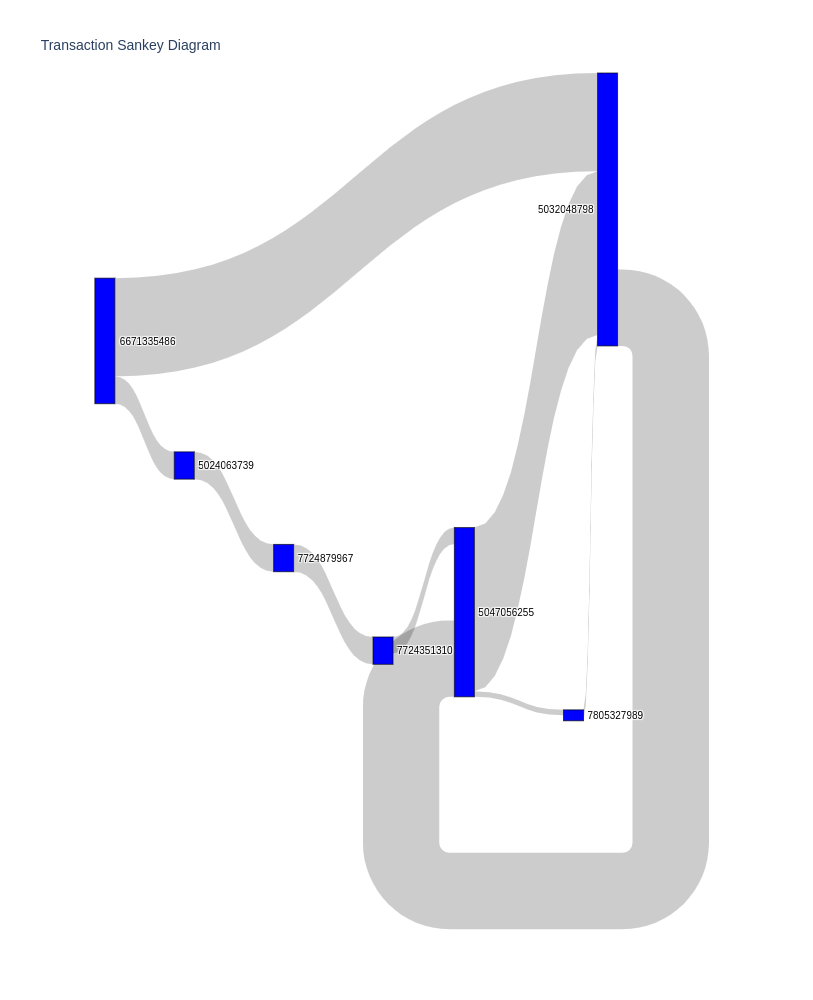

In [964]:
seller_list = ['6671335486',
 '5024063739',
 '7724879967',
 '7724351310',
 '5047056255',
 '7805327989',
 '5032048798']
buyer_list = seller_list.copy()

tmp = transaction_dataframe(seller_list, seller_list, transactions_matrix, inn_list)

label = list(tmp)
arr = tmp.values
source, target = np.where(arr > 0)
value = arr[source, target]

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
fig.update_layout(
#     autosize=False,
    width=1_500,
    height=1_000,)
fig.show()

In [579]:
def filter_zeros(df):
    df = df.copy()
    return df.loc[df.sum(axis=1) > 0, df.sum(axis=0) > 0]

In [604]:
N_INN = 30
seller_list = df.groupby('inn')['vin'].nunique().sort_values(ascending=False).head(N_INN).index.tolist()

In [624]:
TOP_VIN = 3
seller_list = df.loc[df['vin'].isin(df['vin'].value_counts().head(TOP_VIN).index), 'inn'].unique()

In [625]:
tmp = transaction_dataframe(seller_list, seller_list, transactions_matrix, inn_list)
filter_zeros(tmp)

,7718924121,6929004019,7729738092,7716712146,5030080387,7714582540,7841027042,5030083719,5032048798,7734724666,8902013316,6215027878,3123157416,7718273656,7727074520,9705101614,8902013740,7806398710
7729367320,0,0,42,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
7715811730,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7710882864,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7718924121,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6929004019,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
7729738092,0,0,0,0,22,0,0,7,0,0,0,0,0,0,0,0,0,0
7716712146,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
5030080387,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0
7714582540,0,0,0,0,0,0,5,0,0,0,0,2,0,0,0,0,0,0
7841027042,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0


In [668]:
label = list(tmp)
arr = tmp.values
source, target = np.where(arr > 0)
value = arr[source, target]

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
fig.update_layout(
#     autosize=False,
    width=1_500,
    height=1_000,)
fig.show()

In [670]:
seller_list = [inn+'_seller' for inn in tmp.index.tolist()]
buyer_list = [inn+'_buyer' for inn in tmp.columns.tolist()]
label = seller_list + buyer_list

arr = tmp.values
source, target = np.where(arr > 0)
value = arr[source, target]
target += len(source)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
fig.update_layout(
#     autosize=False,
    width=1_500,
    height=1_000,)
fig.show()

# SANKEY

In [801]:
# holding_seller = ['ГМК НОРИЛЬСКИЙ НИКЕЛЬ, ПАО']
# holding_buyer = ['АЛРОСА (ПАО), АК']

# inn_seller = holdings.loc[holdings['Group'].isin(holding_seller), 'INN'].unique().tolist()
# inn_buyer = holdings.loc[holdings['Group'].isin(holding_seller), 'INN'].unique().tolist()

# inn_seller = [inn for inn in inn_seller if inn in inn_list]
# inn_buyer = [inn for inn in inn_buyer if inn in inn_list]

In [1076]:
# Primary inn select
inn_seller = holdings.query('Group == "КАМАЗ, ПАО"').index.unique().tolist()
inn_buyer = holdings.index.unique().tolist()

In [1059]:
holdings

,Group,department,quantity,region
INN,,,,
4620009025,AgroMir Holdings Limited,"Выращивание зерновых (кроме риса), зернобобовы...",8,Курская область
3115004381,AgroMir Holdings Limited,Животноводство,6,Белгородская область
3243003930,AgroMir Holdings Limited,Выращивание зернобобовых культур,3,Брянская область
3252005997,AgroMir Holdings Limited,Смешанное сельское хозяйство,317,Брянская область
3250519281,AgroMir Holdings Limited,Разведение сельскохозяйственной птицы,3,Брянская область
...,...,...,...,...
7718924410,Шленчак Роман Александрович,Строительство автомобильных дорог и автомагист...,2,Москва
3123217312,Шленчак Роман Александрович,Строительство автомобильных дорог и автомагист...,134,Белгородская область
2309129490,Шленчак Роман Александрович,Строительство автомобильных дорог и автомагист...,3,Краснодарский край


In [1178]:
# Primary inn select
inn_seller = holdings.index.unique().tolist()
inn_buyer = holdings.index.unique().tolist()

In [1179]:
%%time

# Transaction matrix creation

print('inn filter')
inn_seller = [inn for inn in inn_seller if inn in inn_list]
inn_buyer = [inn for inn in inn_buyer if inn in inn_list]

inn filter
CPU times: user 6.91 s, sys: 39.5 ms, total: 6.95 s
Wall time: 6.89 s


In [1180]:
print('inn enrichment')
seller_index = holdings.loc[inn_seller].set_index(['Group', 'region', 'department',], append=True)
buyer_index = holdings.loc[inn_buyer].set_index(['Group', 'region', 'department',], append=True)

inn enrichment


In [1181]:
print('index attachment')
transaction_subsample = transaction_dataframe(inn_seller, inn_buyer, transactions_matrix, inn_list)
transaction_subsample.index = seller_index.index
transaction_subsample.columns = buyer_index.index

print('index reorder')
transaction_subsample = transaction_subsample.reorder_levels(['region', 'department', 'Group', 'INN',], axis=0).sort_index()

index attachment
index reorder


In [1182]:
transaction_subsample

INN                                                                                                                                                   3243003930  \
Group                                                                                                                                   AgroMir Holdings Limited   
region                                                                                                                                          Брянская область   
department                                                                                                                      Выращивание зернобобовых культур   
region         department                                         Group                                              INN                                           
Алтайский край Выращивание однолетних культур                     КДВ, АО                                            2267005290                                0   
               Деятельность вспомогательная прочая, связанная ... АЛТАЙКРАЙИМУЩЕСТВО                                 2259001380                                0   
               Добыча и обогащение свинцово-цинковой руды         УРАЛЬСКАЯ ГОРНО-МЕТАЛЛУРГИЧЕСКАЯ КОМПАНИЯ , ОАО... 2259002376                                0   
               Лесозаготовки                                      КОРАЛ, ООО                                         2266021919                                0   
               Передача электроэнергии и технологическое присо... АЛТАЙКРАЙИМУЩЕСТВО                                 2224143922                                0   
...                                                                                                                                                          ...   
NaN            NaN                                                ФСИН РОССИИ                                        5919420184                                0   
                                                                  ХАЙПЕРФУДС ХОЛДИНГ, ООО                            1834100340                                0   
                                                                  ХК ЮЭСЭМ, ООО                                      4633001577                                0   
                                                                  ЧТПЗ, ПАО                                          0278162460                                0   
                                                                  Шленчак Роман Александрович                        0317011876                                0   

INN                                                                                                                                               3252005997  \
Group                                                                                                                               AgroMir Holdings Limited   
region                                                                                                                                      Брянская область   
department                                                                                                                      Смешанное сельское хозяйство   
region         department                                         Group                                              INN                                       
Алтайский край Выращивание однолетних культур                     КДВ, АО                                            2267005290                            0   
               Деятельность вспомогательная прочая, связанная ... АЛТАЙКРАЙИМУЩЕСТВО                                 2259001380                            0   
               Добыча и обогащение свинцово-цинковой руды         УРАЛЬСКАЯ ГОРНО-МЕТАЛЛУРГИЧЕСКАЯ КОМПАНИЯ , ОАО... 2259002376                            0   
               Лесозаготовки                                      КОРАЛ, ООО                   

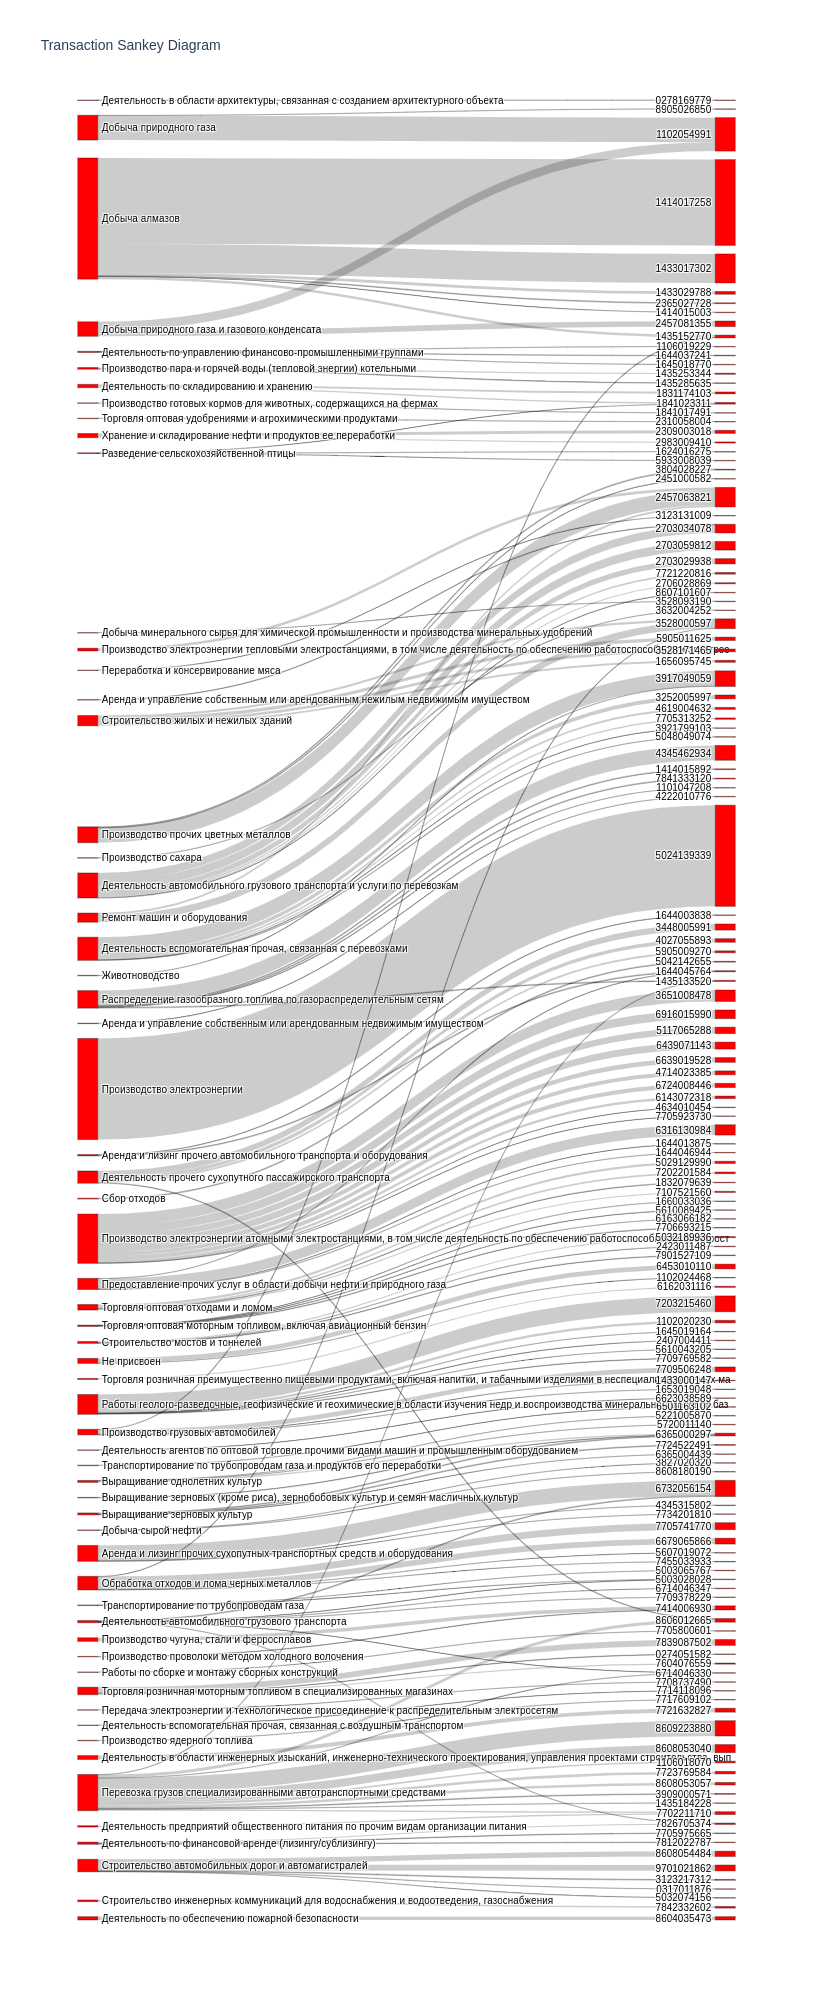

In [1186]:
seller_group = 'Group'
buyer_group = 'INN'


grouped_transaction = group_transaction(transaction_subsample, seller_group, buyer_group)
sankey_2(grouped_transaction).show()

In [1049]:
def group_transaction(df, seller_group, buyer_group):
    return df.groupby(seller_group, axis=0).sum().groupby(buyer_group, axis=1).sum()

In [1185]:
def sankey_1(tmp):
    label = list(tmp)
    arr = tmp.values
    source, target = np.where(arr > 0)
    value = arr[source, target]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = label,
          color = "blue"
        ),
        link = dict(
          source = source,
          target = target,
          value = value
      ))])

    fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
    fig.update_layout(
        autosize=True,
        width=1_500,
        height=2_000,)
    return fig

def sankey_2(tmp):
    seller_list = [inn for inn in tmp.index.tolist()]
    buyer_list = [inn for inn in tmp.columns.tolist()]
    label = seller_list + buyer_list

    arr = tmp.values
    source, target = np.where(arr > 0)
    value = arr[source, target]
    target += len(arr)

    import plotly.graph_objects as go

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.2),
          label = label,
          color = "red"
        ),
        link = dict(
          source = source,
          target = target,
          value = value
      ))])

    fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
    fig.update_layout(
        autosize=True,
        width=1_000,
        height=2_000,)
    return fig

In [1138]:
df

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637211C0EM2028,11,1.0,9.0,NaN,11740.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637210C0EM2030,11,1.0,9.0,NaN,9590.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8-360-031,HDT2,И,4x2,2008.0,Y3M5440A880000074,47,1.0,4.0,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
2013-01-09,1146,С,2001-01-01,МАЗ,437043,HDT1,И,4x2,2008.0,Y3M43704380000253,12,1.0,1.0,NaN,4800.0,5029166093,МЫТИЩИНСКИЙ Р-Н,МЫТИЩИ,Бортовой,None,Московская область,Центральный ФО,Центральный ФО,"регистрация, снятых с учета"
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8,HDT2,И,4x2,2008.0,Y3M5440A880000181,47,1.0,4.0,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,1122,С,2020-03-06,ГАЗ,33088,MDT1,О,4x4,2019.0,XUY3813G0L0000811,11,1.0,55.0,NaN,5450.0,5260200603,NaN,Г НИЖНИЙ НОВГОРОД,Мастерская,None,Нижегородская область,Приволжский ФО,Приволжский ФО,первичная регистрация
2020-03-10,1122,С,2020-03-10,VOLVO,FH TRUCK,HDT2,С,4x2,2013.0,X9PAG20A6DW112147,45,1.0,4.0,NaN,8449.0,5263085388,NaN,Г НИЖНИЙ НОВГОРОД,Тягач седельный,None,Нижегородская область,Приволжский ФО,Приволжский ФО,изменение Ф.И.О. (наименования) владельца
2020-03-10,1122,С,2020-03-10,MERCEDES-BENZ,1840,HDT2,С,4x2,2016.0,Z9M94403250082484,94,1.0,4.0,NaN,7400.0,5261068651,NaN,Г НИЖНИЙ НОВГОРОД,Тягач седельный,None,Нижегородская область,Приволжский ФО,Приволжский ФО,"Изменение собственника по сделкам, произведенн..."


In [1112]:
df_gibdd = pd.read_parquet('../data/processed/gibdd.parquet')

In [1113]:
df_gibdd

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637211C0EM2028,11,1,9,NaN,11740.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-15,1111,С,2013-01-15,КАМАЗ,43118,HDT2,О,6x6,2012.0,X89637210C0EM2030,11,1,9,NaN,9590.0,2901221866,АРХАНГЕЛЬСК. ОБЛ,АРХАНГЕЛЬСК Г,Грузовые прочие,Лесная,Архангельская область,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8-360-031,HDT2,И,4x2,2008.0,Y3M5440A880000074,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
2013-01-09,1146,С,2001-01-01,МАЗ,437043,HDT1,И,4x2,2008.0,Y3M43704380000253,12,1,1,NaN,4800.0,5029166093,МЫТИЩИНСКИЙ Р-Н,МЫТИЩИ,Бортовой,None,Московская область,Центральный ФО,Центральный ФО,"регистрация, снятых с учета"
2013-01-09,1146,С,2001-01-01,МАЗ,5440А8,HDT2,И,4x2,2008.0,Y3M5440A880000181,47,1,4,NaN,8050.0,7710669504,РУЗСКИЙ Р-Н,РУЗА,Тягач седельный,Лизинговая компания,Московская область,Центральный ФО,Центральный ФО,наличие запретов и ограничений
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,1122,С,2020-03-06,ГАЗ,33088,MDT1,О,4x4,2019.0,XUY3813G0L0000811,11,1,55.0,NaN,5450.0,5260200603,None,Г НИЖНИЙ НОВГОРОД,Мастерская,None,Нижегородская область,Приволжский ФО,Приволжский ФО,первичная регистрация
2020-03-10,1122,С,2020-03-10,VOLVO,FH TRUCK,HDT2,С,4x2,2013.0,X9PAG20A6DW112147,45,1,4.0,NaN,8449.0,5263085388,None,Г НИЖНИЙ НОВГОРОД,Тягач седельный,None,Нижегородская область,Приволжский ФО,Приволжский ФО,изменение Ф.И.О. (наименования) владельца
2020-03-10,1122,С,2020-03-10,MERCEDES-BENZ,1840,HDT2,С,4x2,2016.0,Z9M94403250082484,94,1,4.0,NaN,7400.0,5261068651,None,Г НИЖНИЙ НОВГОРОД,Тягач седельный,None,Нижегородская область,Приволжский ФО,Приволжский ФО,"Изменение собственника по сделкам, произведенн..."


In [1236]:
seller_list = df.loc[df['Наименование'] == 'Татарстан']['inn'].unique()
buyer_list = df.loc[df['brand'] == 'КАМАЗ']['inn'].unique()

In [1245]:
seller_list = list(set(seller_list).intersection(set(inn_list)))
buyer_list = list(set(buyer_list).intersection(set(inn_list)))

In [ ]:
seller_ind =get_inn_index(seller_list, inn_list)

In [ ]:
buyer_ind = get_inn_index(buyer_list, inn_list)

In [ ]:
tmp = transaction_dataframe(seller_list[:100], buyer_list[:100], transactions_matrix, inn_list)


KeyboardInterrupt



In [ ]:
sankey_2(grouped_transaction).show()